In [1]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [2]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

170498071/170498071 [==============================] - 4s 0us/step


## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [3]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [4]:
ENCODING_DIM = 120

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [5]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [6]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00372
Test mse: 0.00375


In [7]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

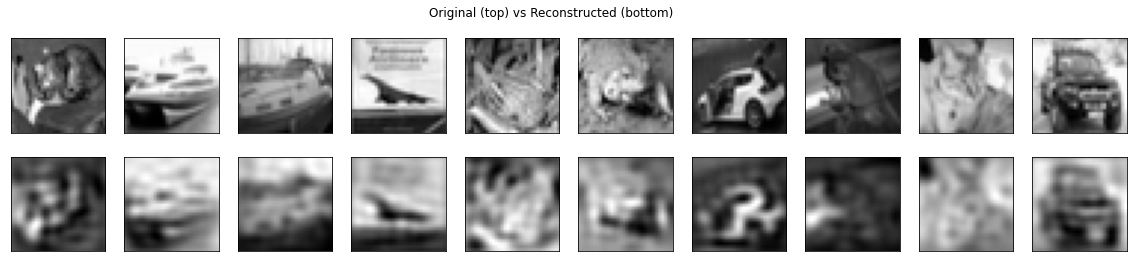

In [8]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

Encoding dimension: 40
Training MSE: 0.00859
Test MSE: 0.00863


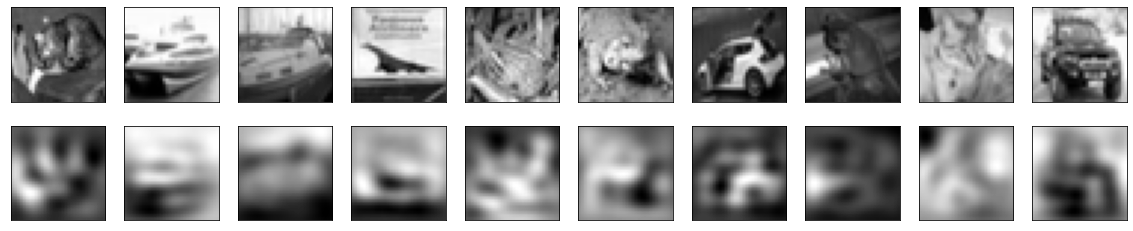

Encoding dimension: 64
Training MSE: 0.00628
Test MSE: 0.00631


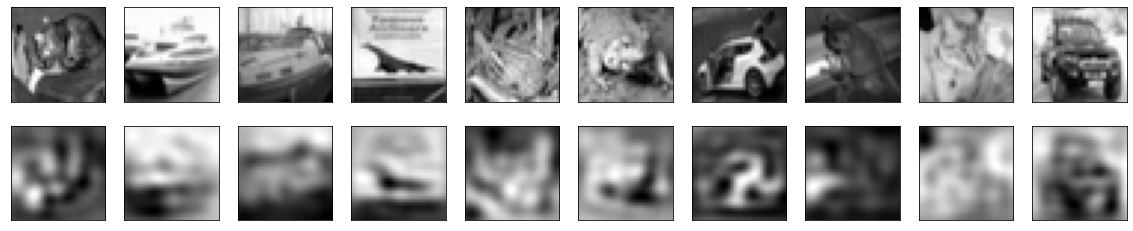

Encoding dimension: 120
Training MSE: 0.00372
Test MSE: 0.00375


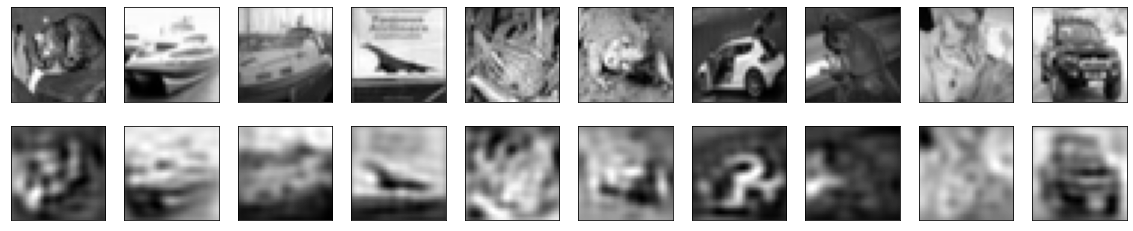

Encoding dimension: 150
Training MSE: 0.00296
Test MSE: 0.00300


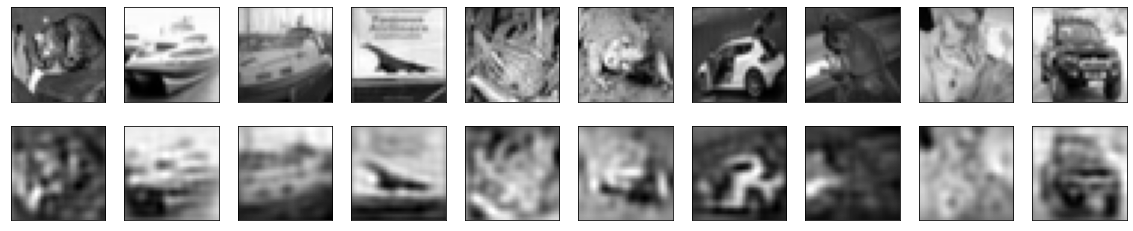

Encoding dimension: 256
Training MSE: 0.00150
Test MSE: 0.00153


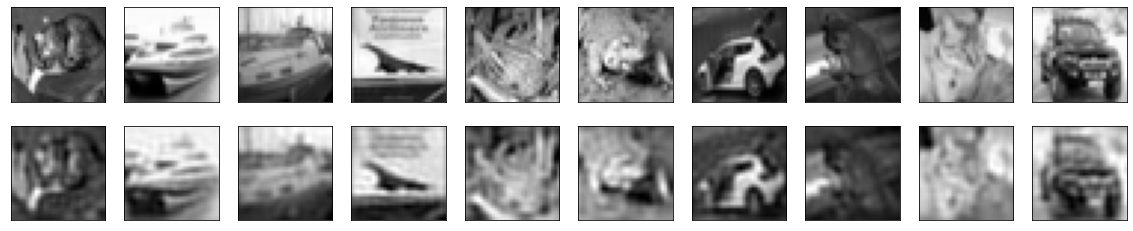

In [ ]:
encoding_dimensions = [40, 64, 120, 150, 256]

for encoding_dim in encoding_dimensions:

  U_k = SVD(x_train, encoding_dim)

  x_training_svd = np.dot(x_train, U_k)
  x_test_svd = np.dot(x_test, U_k)

  x_training_reco = np.dot(x_training_svd, U_k.T)
  x_test_reco = np.dot(x_test_svd, U_k.T)

  accuracy_train = ((x_train - x_training_reco)**2).mean()
  accuracy_test = ((x_test - x_test_reco)**2).mean()

  print('Encoding dimension: {}'.format(str(encoding_dim)))
  print("Training MSE: %.5f" % (accuracy_train))
  print("Test MSE: %.5f" % (accuracy_test))

  plot_img(10, [x_test, x_test_reco])
     

`%STARTEXT`

We can see from the results that the larger the encoding size, the better the image reconstruction. Matrixes with a small encoding dimension are smaller than those with a large encoding dimension. This implies that the execution will take less time.The disadvantage of using a small encoding dimension is that it retains only a subset of the most important information needed for image reconstruction during the decompression phase. Indeed, the MSE (training and test) is larger than those with a larger encoding dimension. With a small encoding dimension, the images are also more blurry.The training and test MSEs are smaller with a larger encoding dimension, and the images are more defined and similar to the originals. As a result, the larger encoding dimension allows for the retention of more important information useful for image reconstruction.

`%ENDTEXT`

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [9]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [11]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 4s 37ms/step - loss: 0.2240 - val_loss: 0.0317
Epoch 2/15
79/79 [==============================] - 3s 35ms/step - loss: 0.0305 - val_loss: 0.0222
Epoch 3/15
79/79 [==============================] - 3s 35ms/step - loss: 0.0207 - val_loss: 0.0328
Epoch 4/15
79/79 [==============================] - 3s 35ms/step - loss: 0.0167 - val_loss: 0.0146
Epoch 5/15
79/79 [==============================] - 3s 35ms/step - loss: 0.0136 - val_loss: 0.0127
Epoch 6/15
79/79 [==============================] - 3s 35ms/step - loss: 0.0127 - val_loss: 0.0115
Epoch 7/15
79/79 [==============================] - 3s 35ms/step - loss: 0.0122 - val_loss: 0.0101
Epoch 8/15
79/79 [==============================] - 3s 35ms/step - loss: 0.0107 - val_loss: 0.0091
Epoch 9/15
79/79 [==============================] - 3s 35ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 10/15
79/79 [==============================] - 3s 35ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [12]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0056 - 775ms/epoch - 2ms/step
Test mse: 0.00565


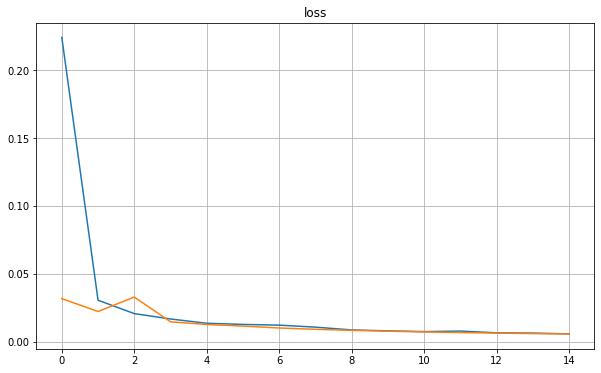

In [13]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

313/313 [==============================] - 1s 2ms/step


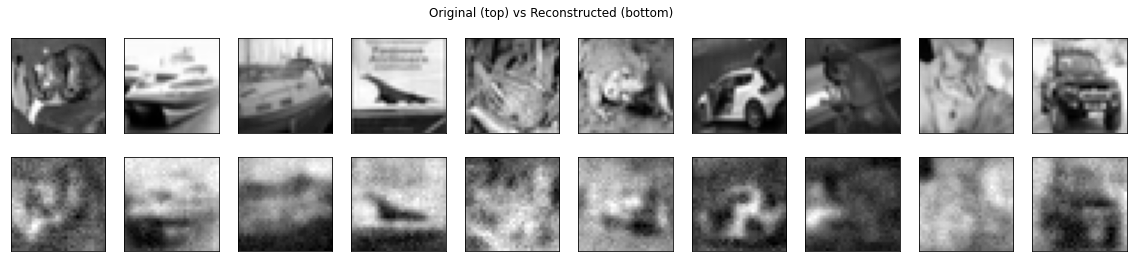

In [14]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]** Check the results and compare them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


_Answer:_

`%STARTEXT`

The results are equivalent since shallow linear autoencoder and singular value decomposition are related. The shallow Linear Autoencoder creates grainier images, while the singular value decomposition creates smooth images. Additionally, there isn't much of a difference between the mse values between SVD and SLA, which are 0.00375 and 0.00565.

`%ENDTEXT`

##[TO COMPLETE] Exercise 5.3: Shallow Non-linear Autoencoders

**[TO COMPLETE]** Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. 

Insert your code and theoretical discussion into cells immediately below this one.


`%STARTCODE`

In [24]:
ENCODING_DIM = 120
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_6 (Dense)             (None, 120)               123000    
                                                                 
 dense_7 (Dense)             (None, 1024)              123904    
                                                                 
Total params: 246,904
Trainable params: 246,904
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
79/79 [==============================] - 2s 25ms/step - loss: 0.0375 - val_loss: 0.0262
Epoch 2/15
79/79 [==============================] - 2s 24ms/step - loss: 0.0211 - val_loss: 0.0184
Epoch 3/15
79/79 [==============================] - 2s 23ms/step - loss: 0.0168 - val_loss: 0.0171
Epoch 4/15
79/79 [==============================] - 2s 23ms/step - loss: 0.0154 - val_loss: 0.0138
Epoch 5/15
79/79 [==============================] - 2s 24ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 6/15
79/79 [==============================] - 2s 23ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 7/15
79/79 [==============================] - 2s 24ms/step - loss: 0.0129 - val_loss: 0.0111
Epoch 8/15
79/79 [==============================] - 2s 23ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 9/15
79/79 [==============================] - 2s 24ms/step - loss: 0.0103 - val_loss: 0.0201
Epoch 10/15
79/79 [==============================] - 2s 24ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 11/

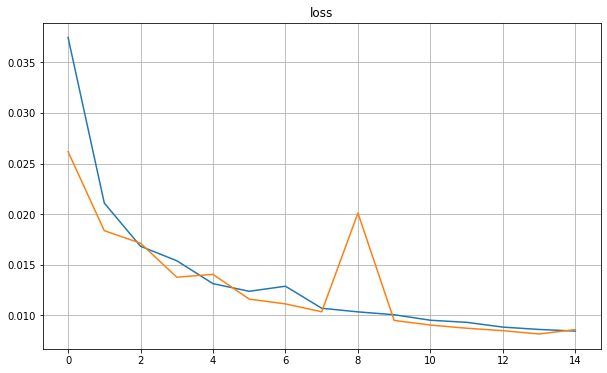

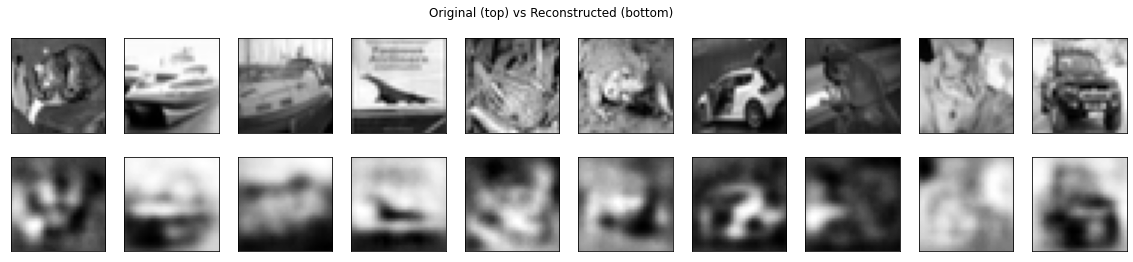

In [25]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

`%ENDCODE`

After executing shallow linear autoencoders and shallow nonlinear autoencoders, we can observe that the mean squared error is nearly identical for both, but the nonlinear autoencoder performs better and produces decoded images that are more detailed (i.e., of high quality).

I experimented with the tanh, sigmoid, and ReLu activation functions for the nonlinear autoencoder. In the end, I decided on the sigmoid model because it produced superior results.

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]** Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


`%STARTCODE`

In [26]:
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))

encoded_1 = tf.keras.layers.Dense(256, activation='sigmoid')(input_img)
encoded_2 = tf.keras.layers.Dense(128, activation='tanh')(encoded_1)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='tanh')(encoded_2)

decoded_1 = tf.keras.layers.Dense(128, activation='tanh')(encoded)
decoded_2 = tf.keras.layers.Dense(256, activation='tanh')(decoded_1)
decoded = tf.keras.layers.Dense(1024, activation='sigmoid')(decoded_2)

autoencoder = tf.keras.models.Model(input_img, decoded) #[TO COMPLETE]

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [27]:
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_8 (Dense)             (None, 256)               262400    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 120)               15480     
                                                                 
 dense_11 (Dense)            (None, 128)               15488     
                                                                 
 dense_12 (Dense)            (None, 256)               33024     
                                                                 
 dense_13 (Dense)            (None, 1024)              263

In [28]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 128, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
313/313 [==============================] - 7s 19ms/step - loss: 0.0267 - val_loss: 0.0216
Epoch 2/15
313/313 [==============================] - 6s 18ms/step - loss: 0.0193 - val_loss: 0.0147
Epoch 3/15
313/313 [==============================] - 5s 17ms/step - loss: 0.0309 - val_loss: 0.0224
Epoch 4/15
313/313 [==============================] - 5s 17ms/step - loss: 0.0234 - val_loss: 0.0346
Epoch 5/15
313/313 [==============================] - 5s 17ms/step - loss: 0.0226 - val_loss: 0.0177
Epoch 6/15
313/313 [==============================] - 5s 17ms/step - loss: 0.0165 - val_loss: 0.0184
Epoch 7/15
313/313 [==============================] - 5s 17ms/step - loss: 0.0149 - val_loss: 0.0157
Epoch 8/15
313/313 [==============================] - 5s 17ms/step - loss: 0.0142 - val_loss: 0.0133
Epoch 9/15
313/313 [==============================] - 5s 17ms/step - loss: 0.0260 - val_loss: 0.0198
Epoch 10/15
313/313 [==============================] - 6s 18ms/step - loss: 0.0153 - val_lo

313/313 - 1s - loss: 0.0180 - 931ms/epoch - 3ms/step
test mse: 0.01798


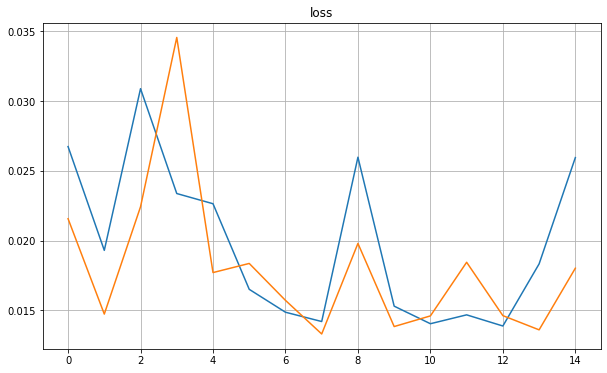

In [29]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

313/313 [==============================] - 1s 3ms/step


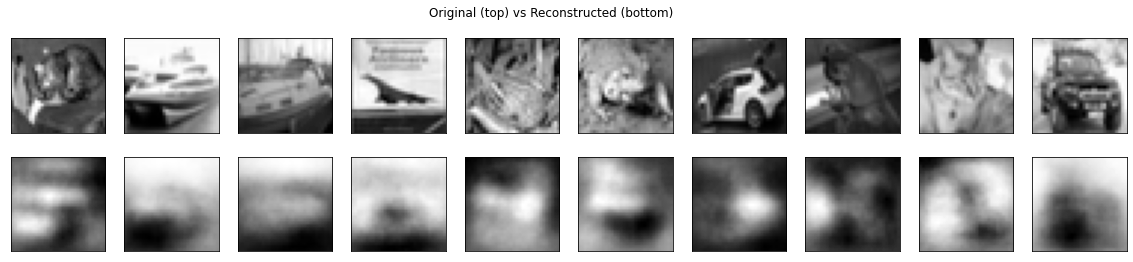

In [30]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

`%ENDCODE`

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [31]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

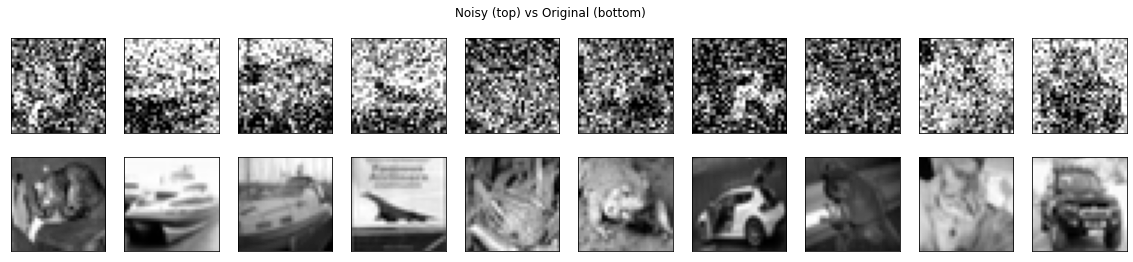

In [32]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$). 

`%STARTCODE`

In [33]:
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(1024, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse') #[TO COMPLETE]

In [34]:
autoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_14 (Dense)            (None, 120)               123000    
                                                                 
 dense_15 (Dense)            (None, 1024)              123904    
                                                                 
Total params: 246,904
Trainable params: 246,904
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [35]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_valid_noisy, x_valid)) #[TO COMPLETE]

Epoch 1/20
313/313 [==============================] - 3s 10ms/step - loss: 0.0263 - val_loss: 0.0189
Epoch 2/20
313/313 [==============================] - 3s 9ms/step - loss: 0.0169 - val_loss: 0.0151
Epoch 3/20
313/313 [==============================] - 3s 9ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 4/20
313/313 [==============================] - 3s 9ms/step - loss: 0.0137 - val_loss: 0.0137
Epoch 5/20
313/313 [==============================] - 3s 9ms/step - loss: 0.0136 - val_loss: 0.0129
Epoch 6/20
313/313 [==============================] - 3s 9ms/step - loss: 0.0127 - val_loss: 0.0125
Epoch 7/20
313/313 [==============================] - 4s 12ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 8/20
313/313 [==============================] - 3s 10ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 9/20
313/313 [==============================] - 3s 9ms/step - loss: 0.0120 - val_loss: 0.0124
Epoch 10/20
313/313 [==============================] - 3s 9ms/step - loss: 0.0120 - val_loss: 0.0

313/313 - 1s - loss: 0.0130 - 642ms/epoch - 2ms/step
Test mse: 0.01295


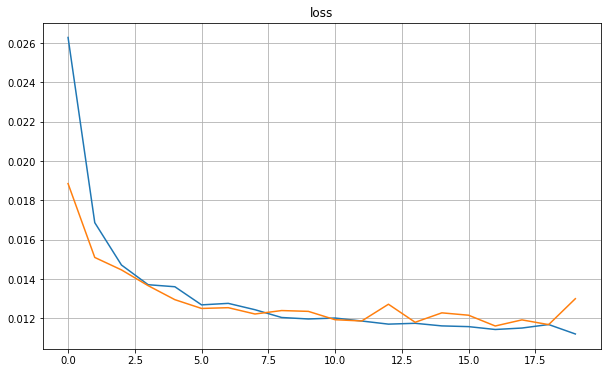

In [36]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

313/313 [==============================] - 1s 2ms/step


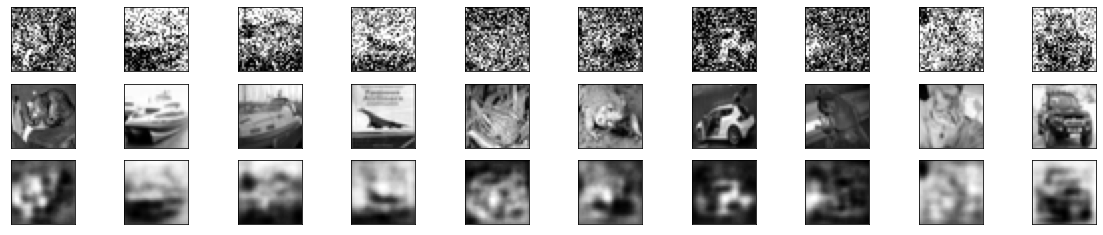

In [37]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

`%ENDCODE`

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [38]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

1641221/1641221 [==============================] - 0s 0us/step


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [39]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [40]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 90, 50)            7550      
                                                                 
 time_distributed (TimeDistr  (None, 90, 100)          5100      
 ibuted)                                                         
                                                                 
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 8s 80ms/step - loss: 0.2518 - categorical_accuracy: 0.0510 - val_loss: 0.1155 - val_categorical_accuracy: 0.1659
Epoch 2/50
79/79 [==============================] - 6s 76ms/step - loss: 0.0896 - categorical_accuracy: 0.3262 - val_loss: 0.0758 - val_categorical_accuracy: 0.3982
Epoch 3/50
79/79 [==============================] - 6s 76ms/step - loss: 0.0692 - categorical_accuracy: 0.4248 - val_loss: 0.0651 - val_categorical_accuracy: 0.4575
Epoch 4/50
79/79 [==============================] - 6s 77ms/step - loss: 0.0605 - categorical_accuracy: 0.4743 - val_loss: 0.0584 - val_categorical_accuracy: 0.4874
Epoch 5/50
79/79 [==============================] - 6s 77ms/step - loss: 0.0556 - categorical_accuracy: 0.5117 - val_loss: 0.0547 - val_categorical_accuracy: 0.5212
Epoch 6/50
79/79 [==============================] - 6s 77ms/step - loss: 0.0546 - categorical_accuracy: 0.5149 - val_loss: 0.0529 - val_categorical_accuracy: 0.5395
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 1s - loss: 0.0113 - categorical_accuracy: 0.9413 - 572ms/epoch - 14ms/step
categorical_accuracy: 94.13%


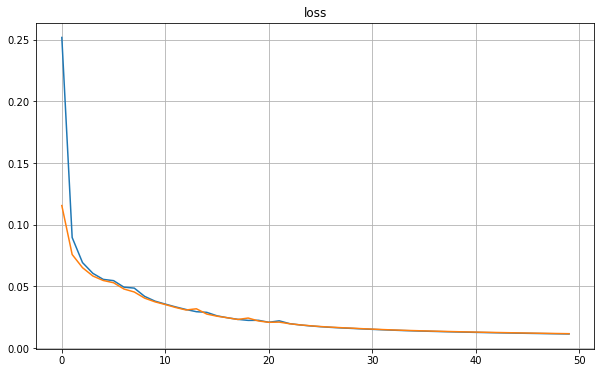

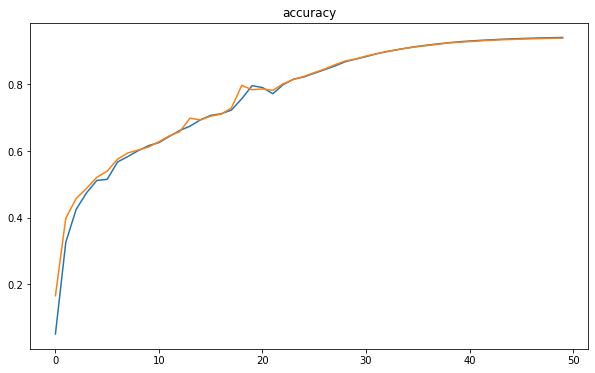

In [42]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [43]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

40/40 [==============================] - 1s 9ms/step
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that <oov> but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some have <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> some <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a only bad film that <oov> <oov> <oov> than i <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

`%STARTCODE`

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()
     

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 lstm (LSTM)                 (None, 90, 50)            30200     
                                                                 
 time_distributed_1 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 15s 160ms/step - loss: 0.0424 - categorical_accuracy: 0.4587 - val_loss: 0.0372 - val_categorical_accuracy: 0.4647
Epoch 2/50
79/79 [==============================] - 13s 161ms/step - loss: 0.0358 - categorical_accuracy: 0.4741 - val_loss: 0.0350 - val_categorical_accuracy: 0.4657
Epoch 3/50
79/79 [==============================] - 12s 151ms/step - loss: 0.0329 - categorical_accuracy: 0.4804 - val_loss: 0.0313 - val_categorical_accuracy: 0.4921
Epoch 4/50
79/79 [==============================] - 12s 152ms/step - loss: 0.0291 - categorical_accuracy: 0.4989 - val_loss: 0.0275 - val_categorical_accuracy: 0.4918
Epoch 5/50
79/79 [==============================] - 13s 167ms/step - loss: 0.0253 - categorical_accuracy: 0.5054 - val_loss: 0.0237 - val_categorical_accuracy: 0.5616
Epoch 6/50
79/79 [==============================] - 13s 169ms/step - loss: 0.0214 - categorical_accuracy: 0.6569 - val_loss: 0.0196 - val_categorical_accuracy: 0.716

40/40 - 1s - loss: 2.7678e-05 - categorical_accuracy: 1.0000 - 752ms/epoch - 19ms/step
categorical_accuracy: 100.00%


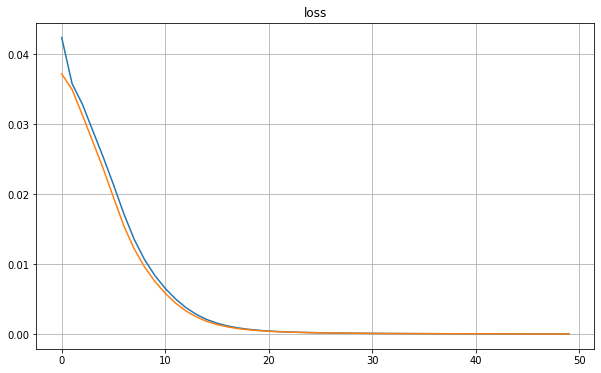

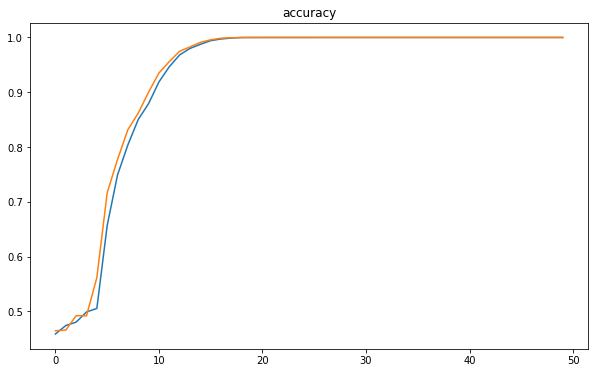

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index = np.argmax(decoded_text[500], axis=1)
input_text = np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

40/40 [==============================] - 1s 17ms/step
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


Due to the classification issue, I used the softmax activation function in the decode and doubled the batch size to 128. I also raised the epochs to 50.

The nonlinear model worked well when compared to the linear model, but it is also overly complex with the same amount of neurons as the linear model with LSTM because there are more factors.

`%ENDCODE`